# Action anticipation for self-driving (JAAD / PIE) — notebook v2

This notebook includes an automatic check: it tries to extract pose features for **all loaded frames** and tells you how many frames ended up as an all-zero vector. It also shows examples of frames with and without detections, so you can diagnose what is happening without guessing.


In [1]:

#@title 0) Enviroment Check
import os, sys, platform
print("Python:", sys.version.split()[0])
print("Platform:", platform.platform())
try:
    import torch
    print("Torch:", torch.__version__, "| CUDA:", torch.cuda.is_available())
except Exception as e:
    print("Torch ainda não importou:", e)


Python: 3.12.12
Platform: Linux-6.6.105+-x86_64-with-glibc2.35
Torch: 2.9.0+cpu | CUDA: False


## 1) Configuration

Edit only this cell. You can run the rest from top to bottom.

In [2]:

#@title 1) Configuração
USE_DRIVE = True
DRIVE_MOUNTPOINT = "/content/drive"

PROJECT_DIR_NAME = "cv_action_anticipation"
DATA_DIR_NAME = "datasets"

DOWNLOAD_JAAD_CLIPS = True
DOWNLOAD_PIE_MINI = True

DEMO_DATASET = "JAAD"          # "JAAD" ou "PIE"
N_FRAMES_TO_READ = 120

OBS_LEN = 16
OVERLAP_JAAD = 0.8
OVERLAP_PIE  = 0.6

POSE_SAMPLE_STEP = 1
POSE_MODEL_COMPLEXITY = 1
MIN_DET_CONF = 0.5
MIN_TRACK_CONF = 0.5


## 2) Mount Drive and create folders

If you enable Drive, your downloads persist across runtime resets.

In [3]:

#@title 2) Montar Drive e criar diretórios
from pathlib import Path

if USE_DRIVE:
    from google.colab import drive
    drive.mount(DRIVE_MOUNTPOINT, force_remount=False)
    ROOT = Path(DRIVE_MOUNTPOINT) / "MyDrive" / PROJECT_DIR_NAME
else:
    ROOT = Path("/content") / PROJECT_DIR_NAME

DATA_ROOT = ROOT / DATA_DIR_NAME
REPO_ROOT = ROOT / "repos"

for p in [ROOT, DATA_ROOT, REPO_ROOT]:
    p.mkdir(parents=True, exist_ok=True)

print("ROOT:", ROOT)
print("DATA_ROOT:", DATA_ROOT)
print("REPO_ROOT:", REPO_ROOT)


Mounted at /content/drive
ROOT: /content/drive/MyDrive/cv_action_anticipation
DATA_ROOT: /content/drive/MyDrive/cv_action_anticipation/datasets
REPO_ROOT: /content/drive/MyDrive/cv_action_anticipation/repos


## 3) Clone repos and copy `jaad_data.py` / `pie_data.py`

This pulls the benchmark repo plus the official JAAD and PIE repos, then copies the dataset interface files into the benchmark folder.

In [4]:

#@title 3) Cloning repos
import os, subprocess
from pathlib import Path

def run(cmd, cwd=None):
    print("+", cmd)
    subprocess.check_call(cmd, shell=True, cwd=cwd)

os.chdir(str(REPO_ROOT))

if not (REPO_ROOT / "PedestrianActionBenchmark").exists():
    run("git clone --depth 1 https://github.com/ykotseruba/PedestrianActionBenchmark.git")

if not (REPO_ROOT / "JAAD").exists():
    run("git clone --depth 1 -b JAAD_2.0 https://github.com/ykotseruba/JAAD.git")

if not (REPO_ROOT / "PIE").exists():
    run("git clone --depth 1 https://github.com/aras62/PIE.git")

print("Repos ready.")


Repos ready.


In [5]:

#@title 3.1) Copy data interface
import shutil
from pathlib import Path

bench = REPO_ROOT / "PedestrianActionBenchmark"
jaad  = REPO_ROOT / "JAAD"
pie   = REPO_ROOT / "PIE"
pie_final = pie / "utilities"

pairs = [(jaad / "jaad_data.py", bench / "jaad_data.py"),
         (pie_final  / "pie_data.py",  bench / "pie_data.py")]

for src, dst in pairs:
    if src.exists():
        shutil.copy2(src, dst)
        print("Copied:", src.name, "->", dst)
    else:
        print("Didn't find:", src)


Copied: jaad_data.py -> /content/drive/MyDrive/cv_action_anticipation/repos/PedestrianActionBenchmark/jaad_data.py
Copied: pie_data.py -> /content/drive/MyDrive/cv_action_anticipation/repos/PedestrianActionBenchmark/pie_data.py


## 4) Install dependencies

These packages cover video loading, MediaPipe Pose, plotting, and a minimal PyTorch model for a smoke test.

In [6]:

#@title 4) Installing dependencis
import sys, subprocess

pkgs = [
    "numpy", "pandas", "pyyaml", "tqdm", "scikit-learn",
    "opencv-python", "matplotlib",
    "gdown",
    "mediapipe==0.10.14"
]
subprocess.check_call([sys.executable, "-m", "pip", "install", "-q"] + pkgs)
print("OK.")


OK.


## 5) Download videos

JAAD is a large zip. PIE is optional here and defaults to a single small demo video when enabled.

In [7]:

#@title 5) Download and extraction of JAAD_clips.zip
import subprocess
from pathlib import Path

JAAD_DIR = DATA_ROOT / "JAAD"
JAAD_DIR.mkdir(parents=True, exist_ok=True)
JAAD_ZIP = JAAD_DIR / "JAAD_clips.zip"
JAAD_ZIP_URL = "https://data.nvision2.eecs.yorku.ca/JAAD_dataset/data/JAAD_clips.zip"

def shell(cmd):
    print("+", cmd)
    subprocess.check_call(cmd, shell=True)

if DOWNLOAD_JAAD_CLIPS:
    if JAAD_ZIP.exists() and JAAD_ZIP.stat().st_size > 10_000_000:
        print("JAAD_clips.zip already exists.")
    else:
        shell(f"wget -c -O '{JAAD_ZIP}' '{JAAD_ZIP_URL}'")

    extracted_flag = JAAD_DIR / ".clips_extracted.ok"
    if extracted_flag.exists():
        print("JAAD already extracted.")
    else:
        shell(f"unzip -q -n '{JAAD_ZIP}' -d '{JAAD_DIR}'")
        extracted_flag.write_text("ok")
        print("Extraction JAAD ok.")
else:
    print("DOWNLOAD_JAAD_CLIPS=False (skipping).")


JAAD_clips.zip already exists.
JAAD already extracted.


In [8]:
#@title 5.1) Extract PIE annotation zips (if they are stored under datasets/PIE/annotations/*.zip)
import subprocess
from pathlib import Path

PIE_DIR = DATA_ROOT / "PIE"
ANN_ZIP_DIR = PIE_DIR / "annotations"

def _unzip(zip_path: Path, dest_dir: Path):
    print("Unzipping:", zip_path.name, "->", dest_dir)
    subprocess.check_call(["unzip", "-q", "-o", str(zip_path), "-d", str(dest_dir)])

def _ensure_sets_at_root(folder: Path):
    """
    pie_data.py expects folders like:
      PIE/annotations/set01, set02, ...
      PIE/annotations_attributes/set01, ...
      PIE/annotations_vehicle/set01, ...
    If unzipping created an extra nested folder with the same name, flatten it.
    """
    if not folder.exists():
        return
    has_set = any(p.is_dir() and p.name.startswith("set") for p in folder.iterdir())
    if has_set:
        return

    nested = folder / folder.name
    if nested.exists() and nested.is_dir():
        nested_has_set = any(p.is_dir() and p.name.startswith("set") for p in nested.iterdir())
        if nested_has_set:
            for item in nested.iterdir():
                target = folder / item.name
                if target.exists():
                    continue
                item.rename(target)
            try:
                nested.rmdir()
            except Exception:
                pass

def _stash_top_level_files(folder: Path):
    """
    pie_data.py assumes entries under PIE/annotations are directories (set01, set02, ...).
    If there are files there (README.md, .zip), move them into folder/_files so generate_database() doesn't crash.
    """
    if not folder.exists():
        return
    stash = folder / "_files"
    stash.mkdir(exist_ok=True)
    for p in list(folder.iterdir()):
        if p.is_file():
            p.rename(stash / p.name)

if not ANN_ZIP_DIR.exists():
    print("No PIE annotations folder found at:", ANN_ZIP_DIR)
else:
    # Zips might be directly inside annotations/ or already moved into annotations/_files/
    zip_files = sorted(ANN_ZIP_DIR.rglob("*.zip"))
    if not zip_files:
        print("No .zip files found in:", ANN_ZIP_DIR)
    else:
        for z in zip_files:
            _unzip(z, PIE_DIR)

        _ensure_sets_at_root(PIE_DIR / "annotations")
        _ensure_sets_at_root(PIE_DIR / "annotations_attributes")
        _ensure_sets_at_root(PIE_DIR / "annotations_vehicle")

        _stash_top_level_files(PIE_DIR / "annotations")
        _stash_top_level_files(PIE_DIR / "annotations_attributes")
        _stash_top_level_files(PIE_DIR / "annotations_vehicle")

        print("Done. Current PIE_DIR contents:")
        for name in ["annotations", "annotations_attributes", "annotations_vehicle"]:
            p = PIE_DIR / name
            if p.exists():
                sub = sorted([x.name for x in p.iterdir() if x.is_dir()])[:10]
                print(f" - {name}/ (example dirs):", sub if sub else "(no subfolders)")
            else:
                print(f" - {name}/ not found")


Unzipping: annotations.zip -> /content/drive/MyDrive/cv_action_anticipation/datasets/PIE
Unzipping: annotations_attributes.zip -> /content/drive/MyDrive/cv_action_anticipation/datasets/PIE
Unzipping: annotations_vehicle.zip -> /content/drive/MyDrive/cv_action_anticipation/datasets/PIE
Done. Current PIE_DIR contents:
 - annotations/ (example dirs): ['_files', 'set01', 'set02', 'set03', 'set04', 'set05', 'set06']
 - annotations_attributes/ (example dirs): ['_files', 'set01', 'set02', 'set03', 'set04', 'set05', 'set06']
 - annotations_vehicle/ (example dirs): ['_files', 'set01', 'set02', 'set03', 'set04', 'set05', 'set06']


In [9]:

#@title 5.2) Download of PIE (1 video) — optional
import subprocess
import shutil
from pathlib import Path

PIE_DIR = DATA_ROOT / "PIE"
PIE_DIR.mkdir(parents=True, exist_ok=True)

PIE_BASE = "https://data.nvision2.eecs.yorku.ca/PIE_dataset/PIE_clips"
PIE_SET = "set01"
PIE_VIDEO = "video_0004.mp4"

dst_dir = PIE_DIR / "PIE_clips" / PIE_SET
dst_dir.mkdir(parents=True, exist_ok=True)
dst = dst_dir / PIE_VIDEO

def shell(cmd):
    print("+", cmd)
    subprocess.check_call(cmd, shell=True)

PIE_REPO = REPO_ROOT / "PIE"

for folder in ["annotations", "annotations_attributes", "annotations_vehicle"]:
  src = PIE_REPO / folder
  dst_folder = PIE_DIR / folder
  if dst_folder.exists():
    continue
  if not src.exists():
    raise FileNotFoundError(f"Didn't find {src}. Look for the location of the file inside repos/PIE")
  shutil.copytree(src, dst_folder)
  print("Copied folder:", folder, "->", dst_folder)

if DOWNLOAD_PIE_MINI:
    if dst.exists() and dst.stat().st_size > 1_000_000:
        print("PIE already exists.")
    else:
        url = f"{PIE_BASE}/{PIE_SET}/{PIE_VIDEO}"
        shell(f"wget -c -O '{dst}' '{url}'")
else:
    print("DOWNLOAD_PIE_MINI=False (skipping).")


PIE already exists.


## 6) Automatically pick a demo video

If you select PIE and the mini PIE video exists, it uses that; otherwise it falls back to the first MP4 found under the JAAD folder.

In [10]:

#@title 6) Automatically find demo video
from pathlib import Path

def find_first_mp4(root: Path):
    mp4s = sorted(root.rglob("*.mp4"))
    return mp4s[0] if mp4s else None

demo_video = None
if DEMO_DATASET.upper() == "PIE":
    candidate = DATA_ROOT / "PIE" / "PIE_clips" / "set01" / "video_0004.mp4"
    demo_video = candidate if candidate.exists() else None

if demo_video is None:
    demo_video = find_first_mp4(DATA_ROOT / "JAAD")

print("DEMO_VIDEO:", demo_video)
assert demo_video is not None, "Didn't find .mp4. Activate DOWNLOAD_JAAD_CLIPS ou DOWNLOAD_PIE_MINI."


DEMO_VIDEO: /content/drive/MyDrive/cv_action_anticipation/datasets/JAAD/JAAD_clips/video_0001.mp4


## 7) Read frames and preview a sample

This helps you confirm whether pedestrians are visible in the portion of the video you loaded.

In [11]:

#@title 7) Read frames of the video
import cv2, numpy as np

def read_n_frames(video_path: str, n: int):
    cap = cv2.VideoCapture(video_path)
    frames = []
    ok, frame = cap.read()
    while ok and len(frames) < n:
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame_rgb)
        ok, frame = cap.read()
    cap.release()
    return np.array(frames)

frames = read_n_frames(str(demo_video), n=N_FRAMES_TO_READ)
print("Frames read:", frames.shape)
assert len(frames) > 0


Frames read: (120, 1080, 1920, 3)


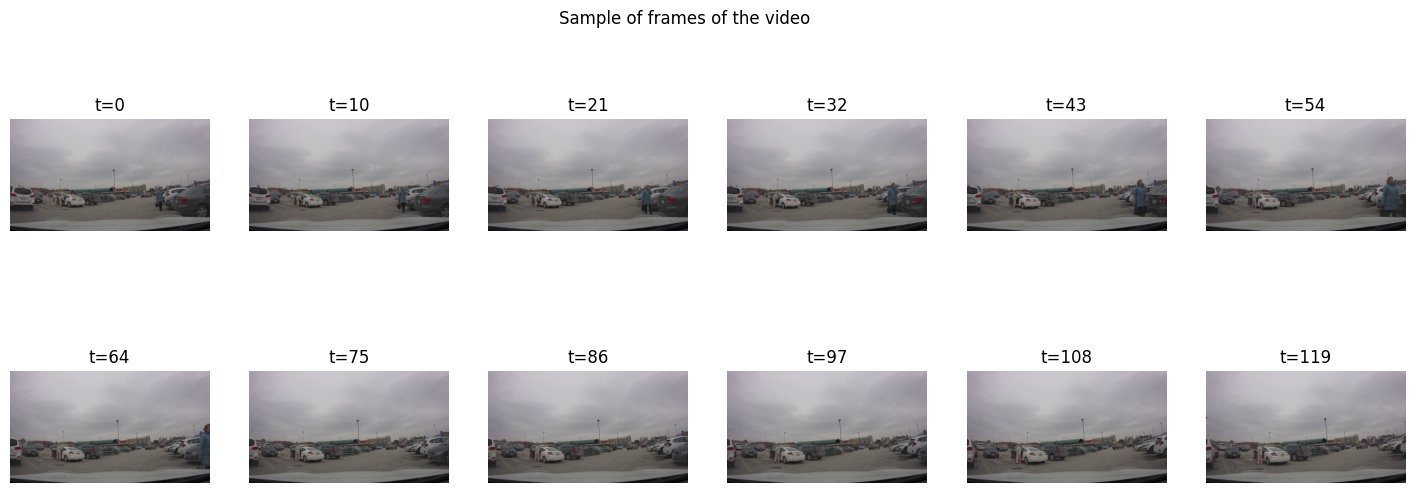

In [12]:

#@title 7.1) Show a sample of frames
import matplotlib.pyplot as plt
import numpy as np

def show_frames(frames_rgb, idxs, title=""):
    idxs = list(idxs)
    n = len(idxs)
    cols = 6
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(3*cols, 3*rows))
    for i, t in enumerate(idxs, 1):
        plt.subplot(rows, cols, i)
        plt.imshow(frames_rgb[t])
        plt.title(f"t={t}")
        plt.axis("off")
    if title:
        plt.suptitle(title)
    plt.show()

idxs = np.linspace(0, len(frames)-1, min(12, len(frames)), dtype=int) if len(frames) > 1 else [0]
show_frames(frames, idxs, title="Sample of frames of the video")


## 8) Windowing with 16 frames and overlap

Each training sample uses a fixed window of 16 consecutive frames. Overlap controls how much two consecutive windows share; higher overlap yields more, highly similar samples.

In [13]:

#@title 8) Creating windows
import math

def make_windows(num_frames: int, obs_len: int, overlap: float):
    assert 0.0 <= overlap < 1.0
    stride = max(1, int(round(obs_len * (1.0 - overlap))))
    windows = []
    for start in range(0, num_frames - obs_len + 1, stride):
        windows.append((start, start + obs_len))
    return stride, windows

overlap = OVERLAP_JAAD if DEMO_DATASET.upper() == "JAAD" else OVERLAP_PIE
stride, windows = make_windows(len(frames), OBS_LEN, overlap)
print("OBS_LEN:", OBS_LEN, "| overlap:", overlap, "| stride:", stride, "| janelas:", len(windows))
print("First 5 windows:", windows[:5])


OBS_LEN: 16 | overlap: 0.8 | stride: 3 | janelas: 35
First 5 windows: [(0, 16), (3, 19), (6, 22), (9, 25), (12, 28)]


## 9) 36D pose for all frames (full check)

This is the main diagnostic step. It processes all loaded frames and records which ones had a pose detected. Frames without detections are stored as a 36D all-zero vector.

In [14]:

#@title 9) Extracting pose 36D for all loaded frames
import numpy as np
import mediapipe as mp

mp_pose = mp.solutions.pose
LANDMARKS_18 = [0,11,12,13,14,15,16,23,24,25,26,27,28,1,2,3,4,5]

def extract_pose36_all(frames_rgb, sample_step=1,
                       model_complexity=1, min_det_conf=0.5, min_track_conf=0.5):
    T = len(frames_rgb)
    feats = np.zeros((T, 36), dtype=np.float32)
    detected = np.zeros((T,), dtype=bool)

    with mp_pose.Pose(
        static_image_mode=False,
        model_complexity=model_complexity,
        min_detection_confidence=min_det_conf,
        min_tracking_confidence=min_track_conf
    ) as pose:
        for t in range(0, T, sample_step):
            res = pose.process(frames_rgb[t])
            if res.pose_landmarks is None:
                continue
            lm = res.pose_landmarks.landmark
            xy = []
            for idx in LANDMARKS_18:
                xy.extend([lm[idx].x, lm[idx].y])
            feats[t] = np.array(xy, dtype=np.float32)
            detected[t] = True
    return feats, detected

pose36, detected = extract_pose36_all(
    frames,
    sample_step=POSE_SAMPLE_STEP,
    model_complexity=POSE_MODEL_COMPLEXITY,
    min_det_conf=MIN_DET_CONF,
    min_track_conf=MIN_TRACK_CONF
)

print("Pose features:", pose36.shape)
print("Frames with pose detected:", int(detected.sum()))
print("Frames without pose (zeros):", int((~detected).sum()))
all_zero = np.isclose(np.abs(pose36).sum(axis=1), 0.0)
print("Frames with 100% zero vector:", int(all_zero.sum()))
print("First indices with pose:", np.where(detected)[0][:30])
print("First indices with zeros:", np.where(all_zero)[0][:30])


/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Pose features: (120, 36)
Frames with pose detected: 32
Frames without pose (zeros): 88
Frames with 100% zero vector: 88
First indices with pose: [35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58
 59 60 61 62 63 64]
First indices with zeros: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]


## 10) Show examples with and without pose

If most frames are zeros, it usually means the pedestrian is too small or far away when running pose on the full frame. In many driving pipelines, pose is applied on pedestrian crops (using bounding boxes) rather than on the full image.

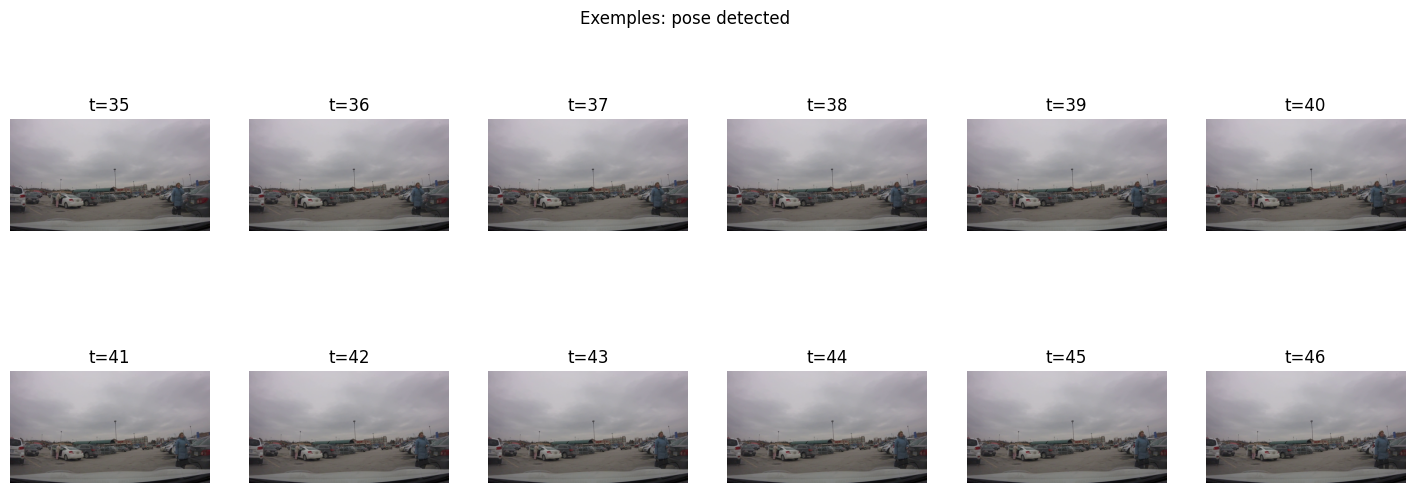

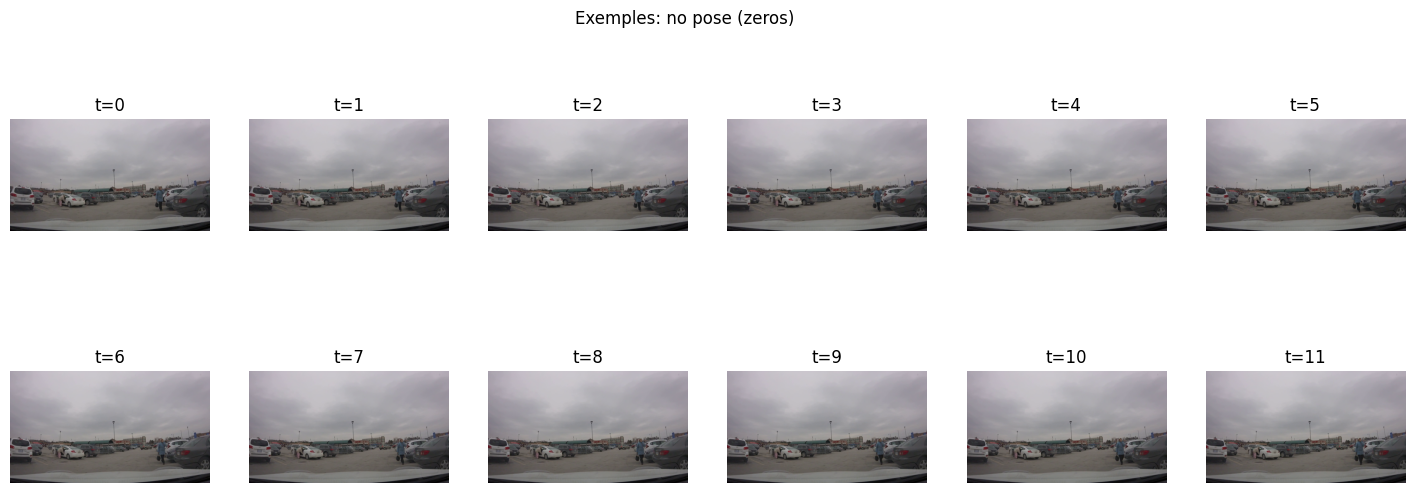

In [15]:

#@title 10) Visualizing examples (pose and no-pose)
import matplotlib.pyplot as plt
import numpy as np

def show_some(frames_rgb, idxs, n=12, title=""):
    idxs = list(idxs)[:n]
    if len(idxs) == 0:
        print("No frame to show:", title)
        return
    cols = 6
    rows = int(np.ceil(len(idxs)/cols))
    plt.figure(figsize=(3*cols, 3*rows))
    for i, t in enumerate(idxs, 1):
        plt.subplot(rows, cols, i)
        plt.imshow(frames_rgb[t])
        plt.title(f"t={t}")
        plt.axis("off")
    if title:
        plt.suptitle(title)
    plt.show()

show_some(frames, np.where(detected)[0], n=12, title="Exemples: pose detected")
show_some(frames, np.where(~detected)[0], n=12, title="Exemples: no pose (zeros)")


## 11) Build windowed dataset (N, 16, 36) and filter weak windows

Here we form the input tensor from the windows. By default, the notebook keeps only windows where at least 25% of frames had a pose detection, so the demo remains meaningful.

In [16]:

#@title 11) Creating X from windows and filtering
import numpy as np

MIN_POSE_RATIO_PER_WINDOW = 0.25

X = []
keep = []
for (a,b) in windows:
    win_feats = pose36[a:b]
    ratio = detected[a:b].mean()
    if ratio >= MIN_POSE_RATIO_PER_WINDOW:
        X.append(win_feats)
        keep.append(True)
    else:
        keep.append(False)

X = np.stack(X, axis=0) if len(X) else np.zeros((0, OBS_LEN, 36), dtype=np.float32)

print("Total windows:", len(windows))
print("Windows kept:", int(np.sum(keep)))
print("X shape:", X.shape)

if X.shape[0] == 0:
    print("No window passed. Make MIN_POSE_RATIO_PER_WINDOW smaller for 0.0 and try again.")


Total windows: 35
Windows kept: 13
X shape: (13, 16, 36)


## 12) Smoke test with an LSTM and dummy labels

This is not the final benchmark evaluation. It is only a quick end-to-end sanity check to confirm that the data pipeline, shapes, and training loop run without relying on official labels yet.

In [17]:

#@title 12) Quick trainning with dummy labels
import numpy as np
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SimpleLSTM(nn.Module):
    def __init__(self, in_dim=36, hidden=64):
        super().__init__()
        self.lstm = nn.LSTM(input_size=in_dim, hidden_size=hidden, batch_first=True)
        self.fc = nn.Linear(hidden, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        return self.fc(last)

if X.shape[0] < 4:
    print("Few windows for demo. Adjust N_FRAMES_TO_READ or the filter.")
else:
    rng = np.random.default_rng(0)
    y = rng.integers(0, 2, size=(X.shape[0],), dtype=np.int64)

    X_t = torch.tensor(X, dtype=torch.float32).to(device)
    y_t = torch.tensor(y, dtype=torch.float32).to(device).view(-1, 1)

    model = SimpleLSTM(in_dim=X.shape[-1]).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.BCEWithLogitsLoss()

    for epoch in range(3):
        opt.zero_grad()
        logits = model(X_t)
        loss = loss_fn(logits, y_t)
        loss.backward()
        opt.step()

        with torch.no_grad():
            probs = torch.sigmoid(logits).detach().cpu().numpy().reshape(-1)
            pred = (probs >= 0.5).astype(np.int64)
            acc = (pred == y).mean()
        print(f"epoch={epoch} loss={loss.item():.4f} acc={acc:.3f} (dummy)")


epoch=0 loss=0.6908 acc=0.462 (dummy)
epoch=1 loss=0.6834 acc=0.462 (dummy)
epoch=2 loss=0.6772 acc=0.462 (dummy)


## 13) Diagnose `jaad_data` and `pie_data` inside the benchmark

When you connect the notebook to the official JAAD/PIE annotations, you will generate real labels from these interfaces. This cell prints what classes and functions exist so you do not have to guess the API.

In [18]:

#@title 13) Diagnosing benchmark modules
import sys, inspect

bench = REPO_ROOT / "PedestrianActionBenchmark"
sys.path.insert(0, str(bench))

def describe_module(modname: str):
    print("\n====", modname, "====")
    try:
        mod = __import__(modname)
    except Exception as e:
        print("Failed to import:", e)
        return None
    print("File:", getattr(mod, "__file__", None))
    classes = [n for n,o in mod.__dict__.items() if inspect.isclass(o) and o.__module__ == mod.__name__]
    funcs   = [n for n,o in mod.__dict__.items() if inspect.isfunction(o) and o.__module__ == mod.__name__]
    print("Classes (partial):", classes[:30], ("..." if len(classes)>30 else ""))
    print("Functions (partial):", funcs[:30], ("..." if len(funcs)>30 else ""))
    return mod

_jaad = describe_module("jaad_data")
_pie  = describe_module("pie_data")



==== jaad_data ====
File: /content/drive/MyDrive/cv_action_anticipation/repos/PedestrianActionBenchmark/jaad_data.py
Classes (partial): ['JAAD'] 
Functions (partial): [] 

==== pie_data ====
File: /content/drive/MyDrive/cv_action_anticipation/repos/PedestrianActionBenchmark/pie_data.py
Classes (partial): ['PIE'] 
Functions (partial): [] 


## 14) Next step

Once you are ready to match the paper setup, replace the dummy labels with real crossing labels from JAAD/PIE and evaluate with the same metrics/protocol. If full-frame pose remains mostly zeros, the natural upgrade is to run pose on pedestrian crops obtained from bounding boxes.

In [19]:
#@title Creating the Labels

import os, pickle
import numpy as np
import importlib.util

p = REPO_ROOT / "PedestrianActionBenchmark" / "pie_data.py"
spec = importlib.util.spec_from_file_location("pie_data", str(p))
pie_data = importlib.util.module_from_spec(spec)
spec.loader.exec_module(pie_data)

PIE = pie_data.PIE

PIE_PATH = str(DATA_ROOT / "PIE")
OBS_LEN = 16
OVERLAP = 0.6
HORIZON_FRAMES = 30 #within the next x frames

def stride_from_overlap(obs_len, overlap):
  return max(1, int(round(obs_len * (1.0 - overlap))))

PIE_SPLITS ={
    "train": {"set01", "set02", "set04"},
    "val" : {"set05", "set06"},
    "test": {"set03"}
}


def which_split(setid):
  for split, sets in PIE_SPLITS.items():
    if setid in sets:
      return split
  return None

pie = PIE(data_path=PIE_PATH, regen_database=False)
db = pie.generate_database() # cached under PIE/data_cache/

stride = stride_from_overlap(OBS_LEN, OVERLAP)
samples = []
labels = []

missing_videos = 0
skipped_tracks = 0

for setid in db:
  split = which_split(setid)
  if split is None:
    continue

  for vid in db[setid]:
    ped_ann = db[setid][vid]["ped_annotations"]

    video_path = os.path.join(PIE_PATH, "PIE_clips", setid, f"{vid}.mp4")
    if not os.path.isfile(video_path):
      missing_videos += 1
      continue

    for pid, ped in ped_ann.items():
      frames = ped["frames"] # list[int]
      bboxes = ped["bbox"] # list[[x1,y1,x2,y2]]
      occ = ped["occlusion"] # list[int]
      attrs = ped.get("attributes", {})

      if len(frames) < OBS_LEN:
        skipped_tracks += 1
        continue

      is_crossing = int(attrs.get("crossing", 0) > 0)

      event_frame = attrs.get("crossing_point", None) if is_crossing else None
      event_idx = None
      if is_crossing and (event_frame in frames):
        event_idx = frames.index(event_frame)
      if is_crossing and event_idx is None:
        skipped_tracks += 1
        continue

      for s in range(0, len(frames) - OBS_LEN + 1, stride):
        e = s + OBS_LEN

        if is_crossing:
          if e > event_idx:
            continue
          time_to_event = event_idx - e
          y = 1 if (0 <= time_to_event < HORIZON_FRAMES) else 0
        else:
          time_to_event = None
          y = 0

        samples.append({
            "dataset" : "PIE",
            "split" : split,
            "setid" : setid,
            "vid" : vid,
            "pid" : pid,
            "video_path" : video_path,
            "frame_ids" : frames[s:e],
            "bboxes" : bboxes[s:e],
            "occlusion" : occ[s:e],
            "is_crossing_track" : is_crossing,
            "event_frame" : int(event_frame) if event_frame is not None else -1,
            "horizon_frames" : int(HORIZON_FRAMES),
            "time_to_event_idx" : int(time_to_event) if time_to_event is not None else -1,
        })
        labels.append(y)

labels = np.array(labels, dtype = np.int64)


print("Built PIE samples:", len(samples))
print("Positive labels:", int(labels.sum()), "| Negative labels:", int((labels==0).sum()))
print("Missing videos:", missing_videos, "| Skipped tracks:", skipped_tracks)
print("Example sample keys:", list(samples[0].keys()) if len(samples) else "none")





---------------------------------------------------------
Generating database for pie
pie annotations loaded from /content/drive/MyDrive/cv_action_anticipation/datasets/PIE/data_cache/pie_database.pkl
Built PIE samples: 353
Positive labels: 15 | Negative labels: 338
Missing videos: 52 | Skipped tracks: 0
Example sample keys: ['dataset', 'split', 'setid', 'vid', 'pid', 'video_path', 'frame_ids', 'bboxes', 'occlusion', 'is_crossing_track', 'event_frame', 'horizon_frames', 'time_to_event_idx']


## Step 15 — Save the processed PIE dataset

This saves the `samples` and `labels` you just created into a single `.pkl` file so your teammates can load it instantly.

In [20]:
#@title Step 15) Save processed PIE dataset (samples + labels)
import pickle
from pathlib import Path

out_dir = DATA_ROOT / "processed"
out_dir.mkdir(parents=True, exist_ok=True)

out_path = out_dir / f"PIE_obs{OBS_LEN}_ov{OVERLAP}_H{HORIZON_FRAMES}.pkl"

payload = {
    "config": {
        "dataset": "PIE",
        "OBS_LEN": OBS_LEN,
        "OVERLAP": OVERLAP,
        "HORIZON_FRAMES": HORIZON_FRAMES,
        "PIE_PATH": PIE_PATH,
    },
    "samples": samples,
    "labels": labels,
}

with open(out_path, "wb") as f:
    pickle.dump(payload, f, protocol=pickle.HIGHEST_PROTOCOL)

print("Saved:", out_path)


Saved: /content/drive/MyDrive/cv_action_anticipation/datasets/processed/PIE_obs16_ov0.6_H30.pkl


## Step 16 — Sanity checks

This quickly verifies the dataset is consistent: same number of samples/labels, correct window length, and basic class balance.

In [21]:
#@title Step 16) Sanity checks for PIE
import numpy as np

assert len(samples) == len(labels), "Mismatch: len(samples) != len(labels)"

bad_len = 0
bad_bbox = 0
bad_occ = 0

# Quick pass (first 5000 samples). Increase or remove the slice for a full pass.
for s in samples[:5000]:
    if len(s["frame_ids"]) != OBS_LEN:
        bad_len += 1
    if len(s["bboxes"]) != OBS_LEN:
        bad_bbox += 1
    if "occlusion" in s and len(s["occlusion"]) != OBS_LEN:
        bad_occ += 1

labels_np = np.asarray(labels, dtype=np.int64)

print("Checked samples:", min(5000, len(samples)))
print("Bad window length:", bad_len)
print("Bad bbox length:", bad_bbox)
print("Bad occlusion length:", bad_occ)

print("Total samples:", len(samples))
print("Positives:", int(labels_np.sum()), "| Negatives:", int((labels_np == 0).sum()))
print("Positive ratio:", float(labels_np.mean()) if len(labels_np) else 0.0)

splits = sorted({s.get("split", "NA") for s in samples})
print("Splits found:", splits)


Checked samples: 353
Bad window length: 0
Bad bbox length: 0
Bad occlusion length: 0
Total samples: 353
Positives: 15 | Negatives: 338
Positive ratio: 0.042492917847025496
Splits found: ['train']


## Step 17 — Build the processed JAAD dataset

This creates the same kind of `samples` + `labels` file for JAAD. It tries to use whatever API your `JAAD` class exposes and falls back to a deterministic split if official split files are not available.

In [22]:
#@title Step 17.1) Make sure JAAD annotations exist (copy from cloned JAAD repo)
import shutil
from pathlib import Path

JAAD_DIR = DATA_ROOT / "JAAD"
JAAD_DIR.mkdir(parents=True, exist_ok=True)
JAAD_REPO = REPO_ROOT / "JAAD"

# The JAAD repo contains the XML annotations folders and split_ids.
# The JAAD interface expects these under <JAAD_PATH>/... alongside JAAD_clips/.
for folder in [
    "annotations",
    "annotations_attributes",
    "annotations_vehicle",
    "annotations_appearance",
    "annotations_traffic",
    "split_ids",
]:
    src = JAAD_REPO / folder
    dst = JAAD_DIR / folder
    if dst.exists():
        continue
    if not src.exists():
        raise FileNotFoundError(f"Missing {src}. Did the repo clone in Step 3 succeed?")
    shutil.copytree(src, dst)
    print("Copied folder:", folder, "->", dst)

print("JAAD annotations ready.")


JAAD annotations ready.


In [23]:
#@title Step 17.2) JAAD prep: ensure annotations .xml are in the right place + force DB rebuild
from pathlib import Path
import shutil

JAAD_DIR = DATA_ROOT / "JAAD"
ann = JAAD_DIR / "annotations"

# If annotations are nested (annotations/annotations/*.xml), flatten one level.
if ann.exists():
    xml_here = list(ann.glob("*.xml"))
    if len(xml_here) == 0:
        # find a single nested folder that contains xml
        nested_candidates = [p for p in ann.iterdir() if p.is_dir()]
        for nd in nested_candidates:
            xml_nested = list(nd.glob("*.xml"))
            if xml_nested:
                print("Flattening:", nd, "->", ann)
                for x in xml_nested:
                    target = ann / x.name
                    if not target.exists():
                        shutil.move(str(x), str(target))
                break

# Force regenerate JAAD database by removing the cached pickle (it can be empty from earlier runs).
cache = JAAD_DIR / "data_cache" / "jaad_database.pkl"
if cache.exists():
    cache.unlink()
    print("Deleted cached JAAD DB:", cache)
else:
    print("No cached JAAD DB found (ok).")

# Quick visibility checks
if ann.exists():
    print("JAAD annotations .xml count:", len(list(ann.glob('*.xml'))))
else:
    print("JAAD annotations folder missing:", ann)


Deleted cached JAAD DB: /content/drive/MyDrive/cv_action_anticipation/datasets/JAAD/data_cache/jaad_database.pkl
JAAD annotations .xml count: 0


## Step 18 — JAAD (prepare → generate DB → build samples)

This is split into smaller cells so it’s easier to debug.

In [24]:
#@title Step 18.1) JAAD prep (make sure datasets/JAAD/annotations has .xml) + force DB rebuild
import shutil
from pathlib import Path

JAAD_DIR = DATA_ROOT / "JAAD"
JAAD_DIR.mkdir(parents=True, exist_ok=True)

JAAD_REPO = REPO_ROOT / "JAAD"

def _count_xml(folder: Path) -> int:
    return len(list(folder.glob("*.xml"))) if folder.exists() else 0

def _clean_and_fill_xml(folder_name: str):
    dst = JAAD_DIR / folder_name
    dst.mkdir(parents=True, exist_ok=True)

    # 1) If someone extracted into a nested folder, flatten .xml up to dst/*.xml
    for sub in list(dst.iterdir()):
        if sub.is_dir():
            for x in sub.rglob("*.xml"):
                target = dst / x.name
                if not target.exists():
                    shutil.move(str(x), str(target))

    # 2) Remove non-xml files from dst (stash outside so JAAD doesn't treat them as video ids)
    stash = JAAD_DIR / f"_{folder_name}_files"
    stash.mkdir(exist_ok=True)
    for p in list(dst.iterdir()):
        if p.is_file() and p.suffix.lower() != ".xml":
            shutil.move(str(p), str(stash / p.name))

    # 3) Remove stray directories (JAAD lists directory names too and then tries <name>.xml)
    for sub in list(dst.iterdir()):
        if sub.is_dir():
            # if it still contains xml, move them up
            for x in sub.rglob("*.xml"):
                target = dst / x.name
                if not target.exists():
                    shutil.move(str(x), str(target))
            # try to delete the dir if empty
            try:
                sub.rmdir()
            except Exception:
                pass

    # 4) If still empty, copy .xml from the cloned JAAD repo (does NOT overwrite existing)
    if _count_xml(dst) == 0:
        src = JAAD_REPO / folder_name
        if not src.exists():
            print(f"Repo folder missing: {src} (cannot repopulate {dst})")
        else:
            copied = 0
            for x in src.rglob("*.xml"):
                target = dst / x.name
                if not target.exists():
                    shutil.copy2(str(x), str(target))
                    copied += 1
            print(f"Repopulated {folder_name}: copied {copied} xml files from repo")

    print(f"{folder_name}: xml files =", _count_xml(dst))

# The JAAD loader expects at least JAAD/annotations/*.xml
_clean_and_fill_xml("annotations")

# Optional: keep other annotation folders if present (won't break if repo doesn't have them)
for extra in ["annotations_attributes", "annotations_vehicle", "annotations_appearance", "annotations_traffic"]:
    if (JAAD_REPO / extra).exists() or (JAAD_DIR / extra).exists():
        _clean_and_fill_xml(extra)

# Split ids are not xml; just copy them if missing (keeps your structure consistent)
split_dst = JAAD_DIR / "split_ids"
if not split_dst.exists():
    split_src = JAAD_REPO / "split_ids"
    if split_src.exists():
        shutil.copytree(split_src, split_dst)
        print("Copied split_ids ->", split_dst)

# Force regenerate JAAD database by removing the cached pickle (it can be empty from earlier runs).
cache = JAAD_DIR / "data_cache" / "jaad_database.pkl"
if cache.exists():
    cache.unlink()
    print("Deleted cached JAAD DB:", cache)
else:
    print("No cached JAAD DB found (ok).")


Repopulated annotations: copied 346 xml files from repo
annotations: xml files = 346
Repopulated annotations_attributes: copied 346 xml files from repo
annotations_attributes: xml files = 346
Repopulated annotations_vehicle: copied 346 xml files from repo
annotations_vehicle: xml files = 346
Repopulated annotations_appearance: copied 346 xml files from repo
annotations_appearance: xml files = 346
Repopulated annotations_traffic: copied 346 xml files from repo
annotations_traffic: xml files = 346
No cached JAAD DB found (ok).


In [25]:
#@title Step 18.2) Generate JAAD database (and verify it's not empty)
import importlib.util
import traceback
from pathlib import Path

p = REPO_ROOT / "PedestrianActionBenchmark" / "jaad_data.py"
spec = importlib.util.spec_from_file_location("jaad_data", str(p))
jaad_mod = importlib.util.module_from_spec(spec)
spec.loader.exec_module(jaad_mod)
JAAD = jaad_mod.JAAD

JAAD_PATH = str(DATA_ROOT / "JAAD")

# Instantiate with the most common constructor arg name(s)
jaad = None
for kw in [{"data_path": JAAD_PATH}, {"jaad_path": JAAD_PATH}, {"root_path": JAAD_PATH}, {"path": JAAD_PATH}, {}]:
    try:
        jaad = JAAD(**{k: v for k, v in kw.items() if k in JAAD.__init__.__code__.co_varnames})
        break
    except Exception:
        continue

if jaad is None:
    raise RuntimeError("Could not instantiate JAAD class.")

try:
    db = jaad.generate_database()
except Exception:
    print("JAAD.generate_database() failed with this error:")
    traceback.print_exc()
    raise

if not isinstance(db, dict):
    print("DB type:", type(db))
    raise RuntimeError("JAAD database is not a dict; cannot continue with this pipeline.")

print("JAAD db videos:", len(db))
print("Sample keys:", list(db.keys())[:10])


---------------------------------------------------------
Generating database for jaad
Getting annotations for video_0001
Getting annotations for video_0002
Getting annotations for video_0003
Getting annotations for video_0004
Getting annotations for video_0005
Getting annotations for video_0006
Getting annotations for video_0007
Getting annotations for video_0008
Getting annotations for video_0009
Getting annotations for video_0010
Getting annotations for video_0011
Getting annotations for video_0012
Getting annotations for video_0013
Getting annotations for video_0014
Getting annotations for video_0015
Getting annotations for video_0016
Getting annotations for video_0017
Getting annotations for video_0018
Getting annotations for video_0019
Getting annotations for video_0020
Getting annotations for video_0021
Getting annotations for video_0022
Getting annotations for video_0023
Getting annotations for video_0024
Getting annotations for video_0025
Getting annotations for video_0026
Get

In [26]:
#@title Step 18.3) Build JAAD samples + labels from DB and save
import os, pickle, hashlib
import numpy as np
from pathlib import Path

OBS_LEN_JAAD = 16
OVERLAP_JAAD = 0.8
HORIZON_FRAMES_JAAD = HORIZON_FRAMES  # reuse your PIE horizon

def stride_from_overlap(obs_len, overlap):
    return max(1, int(round(obs_len * (1.0 - overlap))))

def stable_split_id(key: str):
    h = int(hashlib.md5(key.encode("utf-8")).hexdigest(), 16) % 100
    if h < 70: return "train"
    if h < 85: return "val"
    return "test"

# Index mp4 files under JAAD_PATH for fast lookup
jaad_root = Path(JAAD_PATH)
mp4_index = {f.stem: str(f) for f in jaad_root.rglob("*.mp4")}

def resolve_video_path(vid):
    vid = str(vid)
    stem = Path(vid).stem
    return mp4_index.get(stem, mp4_index.get(vid))

stride = stride_from_overlap(OBS_LEN_JAAD, OVERLAP_JAAD)

jaad_samples = []
jaad_labels = []
missing_videos = 0
skipped_tracks = 0

# Expect the benchmark-style structure: db[vid]["ped_annotations"][pid] = {...}
for vid, rec in db.items():
    if not isinstance(rec, dict) or "ped_annotations" not in rec:
        continue

    video_path = resolve_video_path(vid)
    if video_path is None or (not os.path.isfile(video_path)):
        missing_videos += 1
        continue

    split = stable_split_id(f"JAAD::{vid}")
    ped_ann = rec.get("ped_annotations", {})

    for pid, ped in ped_ann.items():
        frames = ped.get("frames") or ped.get("frame_ids")
        bboxes = ped.get("bbox") or ped.get("bboxes")
        occ = ped.get("occlusion") or ped.get("occ")
        attrs = ped.get("attributes", {})

        if frames is None or bboxes is None:
            skipped_tracks += 1
            continue

        frames = list(frames)
        bboxes = list(bboxes)
        if occ is None:
            occ = [0] * len(frames)
        else:
            occ = list(occ)

        if len(frames) < OBS_LEN_JAAD:
            skipped_tracks += 1
            continue

        crossing_val = attrs.get("crossing", ped.get("crossing", 0))
        is_crossing = int(crossing_val > 0)

        event_frame = None
        for k in ["crossing_point", "crossingPoint", "crossing_frame", "event_frame"]:
            if k in attrs:
                event_frame = attrs[k]; break
            if k in ped:
                event_frame = ped[k]; break

        event_idx = None
        if is_crossing and (event_frame in frames):
            event_idx = frames.index(event_frame)

        if is_crossing and event_idx is None:
            skipped_tracks += 1
            continue

        for s in range(0, len(frames) - OBS_LEN_JAAD + 1, stride):
            e = s + OBS_LEN_JAAD

            if is_crossing:
                if e > event_idx:
                    continue
                time_to_event = event_idx - e
                y = 1 if (0 <= time_to_event < HORIZON_FRAMES_JAAD) else 0
            else:
                time_to_event = None
                y = 0

            jaad_samples.append({
                "dataset": "JAAD",
                "split": split,
                "vid": str(vid),
                "pid": str(pid),
                "video_path": video_path,
                "frame_ids": frames[s:e],
                "bboxes": bboxes[s:e],
                "occlusion": occ[s:e],
                "is_crossing_track": is_crossing,
                "event_frame": int(event_frame) if event_frame is not None else -1,
                "horizon_frames": int(HORIZON_FRAMES_JAAD),
                "time_to_event_idx": int(time_to_event) if time_to_event is not None else -1,
            })
            jaad_labels.append(y)

jaad_labels = np.array(jaad_labels, dtype=np.int64)

print("Built JAAD samples:", len(jaad_samples))
print("Positive labels:", int(jaad_labels.sum()), "| Negative labels:", int((jaad_labels==0).sum()))
print("Missing videos:", missing_videos, "| Skipped tracks:", skipped_tracks)

out_dir = DATA_ROOT / "processed"
out_dir.mkdir(parents=True, exist_ok=True)
out_path = out_dir / f"JAAD_obs{OBS_LEN_JAAD}_ov{OVERLAP_JAAD}_H{HORIZON_FRAMES_JAAD}.pkl"

payload = {
    "config": {
        "dataset": "JAAD",
        "OBS_LEN": OBS_LEN_JAAD,
        "OVERLAP": OVERLAP_JAAD,
        "HORIZON_FRAMES": HORIZON_FRAMES_JAAD,
        "JAAD_PATH": JAAD_PATH,
        "split_strategy": "stable_hash_70_15_15",
    },
    "samples": jaad_samples,
    "labels": jaad_labels,
}

with open(out_path, "wb") as f:
    pickle.dump(payload, f, protocol=pickle.HIGHEST_PROTOCOL)

print("Saved:", out_path)


Built JAAD samples: 91356
Positive labels: 2267 | Negative labels: 89089
Missing videos: 0 | Skipped tracks: 310
Saved: /content/drive/MyDrive/cv_action_anticipation/datasets/processed/JAAD_obs16_ov0.8_H30.pkl
